In [34]:
import sys
new_python_path = '/n/holyscratch01/dvorkin_lab/nephremidze/abell-s1063/small_masks/delaunay/CAB_with_Delaunay/'
sys.path.append(new_python_path)

#################### Loading necessary packages
import numpy as np
from numpy.polynomial import Polynomial

import dynesty
import pyswarms as ps
from multiprocessing import Pool

import func_utils as fu
import modeling_utils as mu
import modeling_utils_triangle as mu_trig

import matplotlib
import matplotlib.pyplot as plt

import pickle

from lenstronomy.LensModel.lens_model import LensModel

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

cnk = 1

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 30}
matplotlib.rc('font', **font)
#rcnew = {"mathtext.fontset" : "stix"}
#plt.rcParams.update(rcnew)

#matplotlib.rcParams["axes.labelpad"] = 100.
matplotlib.rcParams['axes.linewidth'] = 2.5


deltaPix = 0.031230659851709842*cnk  #  pixel size in arcsec (area per pixel = deltaPix**2)
exp_time = 1.
sigma_bkg = 1.

#######################################################
# Import the JWST images and error files

filt = '200'
mask_type = 'small_masks'
frac_pix = 2

file_path = f"/n/home02/nephremidze/cab_survey/abell-s1063/extract_data/f{filt}w/"

array200sci = np.load(file_path+f'f{filt}w_image1_.npy')
array200err = np.load(file_path+f'f{filt}w_error1_.npy')

array200sci2 = np.load(file_path+f'f{filt}w_image2_.npy')
array200err2 = np.load(file_path+f'f{filt}w_error2_.npy')

array200sci3 = np.load(file_path+f'f{filt}w_image3_.npy')
array200err3 = np.load(file_path+f'f{filt}w_error3_.npy')

psfarray_load = np.load(f'/n/home02/nephremidze/cab_survey/abell-s1063/psf_calculation/jwst_psf_{filt}_sim.npy')

#psfarray = np.zeros([15,15])
#psfarray[7,7] = 1.#
psfarray = psfarray_load[45-7:45+8,45-7:45+8]


In [35]:
# original masks

if mask_type == 'large_masks':
    likemask = fu.makemask(array200sci,30./cnk,60./cnk,0.8)
    likemask2 = fu.makemask(array200sci2,30./cnk,60./cnk,1.7)
    likemask3 = fu.makemask(array200sci3,30./cnk,60./cnk,0.5)
    
elif mask_type == 'small_masks':
    likemask = fu.makemask(array200sci,15./cnk,50./cnk,0.8)
    likemask2 = fu.makemask(array200sci2,15/cnk,50./cnk,1.7)
    likemask3 = fu.makemask(array200sci3,15./cnk,50./cnk,0.5)


2.112420115752648e-06 : 2.1087156433112714e-06


/tmp/ipykernel_431959/2999207683.py:87: RuntimeWarning: invalid value encountered in log10
  vmax = np.nanmax(np.log10(array200sci))
/tmp/ipykernel_431959/2999207683.py:93: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(dataglued*likemaskglued), origin='lower',extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
/tmp/ipykernel_431959/2999207683.py:93: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(dataglued*likemaskglued), origin='lower',extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)


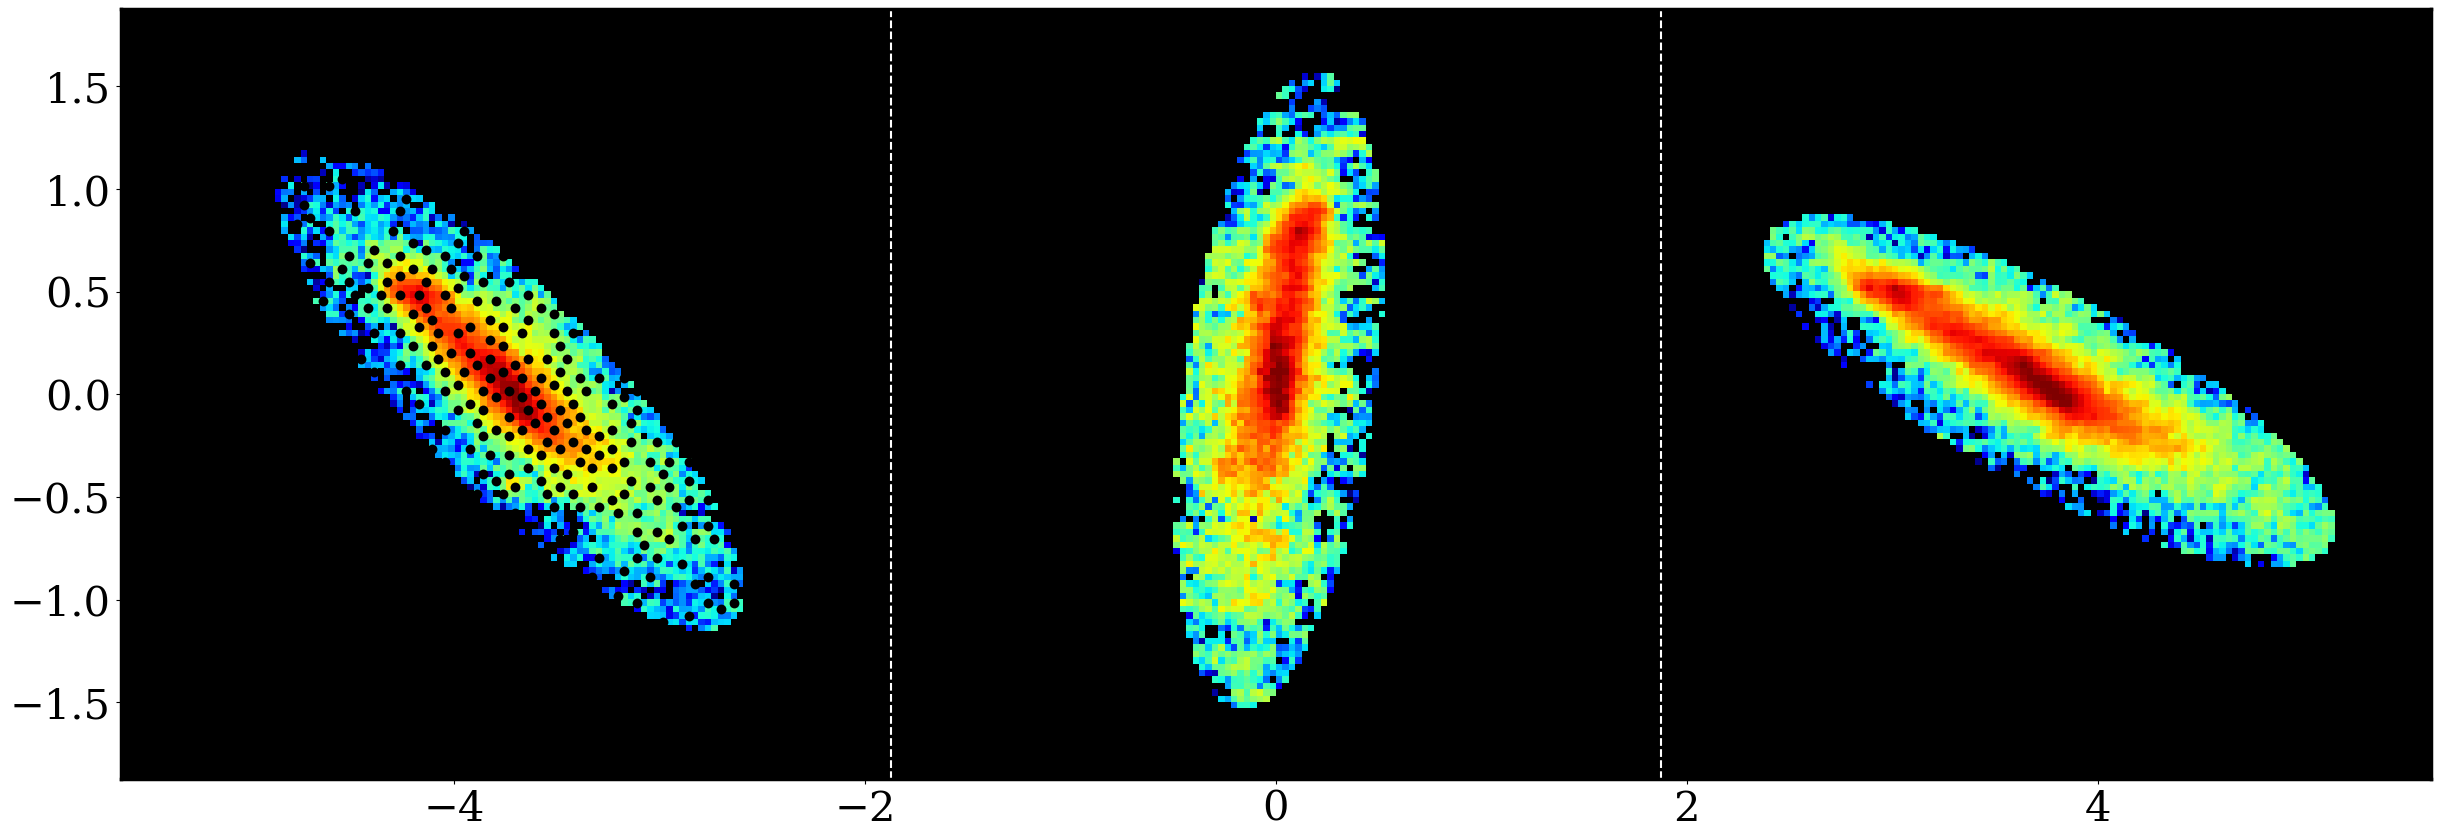

In [36]:
def arrayflip(array):
    shp = np.shape(array)
    newarray = np.zeros(shp)
    for i in range(shp[0]):
        for j in range(shp[1]):
            newarray[i,j] = array[-i,-j]
    return newarray

likemaskglued = np.zeros([np.shape(likemask)[0],int(3*np.shape(likemask)[0])])
dataglued = np.zeros([np.shape(likemask)[0],int(3*np.shape(likemask)[0])])
errglued = np.zeros([np.shape(likemask)[0],int(3*np.shape(likemask)[0])])

likemaskglued[:,:np.shape(likemask)[0]] = likemask
likemaskglued[:,np.shape(likemask)[0]:int(2*np.shape(likemask)[0])] = likemask2
likemaskglued[:,int(2*np.shape(likemask)[0]):int(3*np.shape(likemask)[0])] = likemask3


dataglued[:,:np.shape(likemask)[0]] = array200sci
dataglued[:,np.shape(likemask)[0]:int(2*np.shape(likemask)[0])] = array200sci2
dataglued[:,int(2*np.shape(likemask)[0]):int(3*np.shape(likemask)[0])] = array200sci3


errglued[:,:np.shape(likemask)[0]] = array200err
errglued[:,np.shape(likemask)[0]:int(2*np.shape(likemask)[0])] = array200err2
errglued[:,int(2*np.shape(likemask)[0]):int(3*np.shape(likemask)[0])] = array200err3
#dataglued = np.zeros([np.]

flatdata,flatcoords = fu.flatten_data(dataglued,deltaPix,likemaskglued)
flaterr,_ = fu.flatten_data(errglued,deltaPix,likemaskglued)

def get_hessian_determinant(array2d):
    xder,yder = np.gradient(array2d)
    xxder,xyder = np.gradient(xder)
    yxder,yyder = np.gradient(yder)
    hesdet = xxder*yyder - xyder*yxder
    return np.abs(hesdet)

hesdet = np.abs(get_hessian_determinant(dataglued))
hesflat, coords = fu.flatten_data(hesdet,deltaPix,likemaskglued)

medhest = np.median(hesflat*flatdata)
indx = 0
stop = True

numberchose = int(len(flatdata)/frac_pix)
sdat, scord = fu.get_tessalation_pixels(hesflat*flatdata,coords,int(numberchose),1)
print(sdat[-1],':',medhest)

def remove_neighbors(cordlist,n_index,dPix):
    cordfinal = []
    cordfinal.append(cordlist[0])
    for i in range(1,len(cordlist)):
        candid = cordlist[i]
        dist = 1e5*dPix
        for j in range(len(cordfinal)):
            dist_can = np.linalg.norm(candid - cordfinal[j])
            dist = min(dist,dist_can)
        if dist > n_index*dPix:
            cordfinal.append(candid)
    cordfinal = np.array(cordfinal)
    return cordfinal

vpos = 0.5*deltaPix*np.shape(likemask)[0]
scord_1 = []
for i in range(len(scord)):
    if scord[i,0] < -vpos:
        scord_1.append(scord[i])
scord_1 = np.array(scord_1)

vpos = 0.5*deltaPix*np.shape(likemask)[0]
scord_2 = []
for i in range(len(scord)):
    if scord[i,0] > -vpos and scord[i,0] < vpos:
        scord_2.append(scord[i])
scord_2 = np.array(scord_2)

scord_filter = remove_neighbors(scord_1,2.0001,deltaPix)

cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

scal = 1
f, ax = plt.subplots(1, 1, figsize=(30*scal,10*scal))

vmax = np.nanmax(np.log10(array200sci))
vmin = vmax - 2.

vpos = 0.5*deltaPix*np.shape(likemask)[0]
extent = [-3.*vpos,3.*vpos,-vpos,vpos]

ax.imshow(np.log10(dataglued*likemaskglued), origin='lower',extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
ax.scatter(scord_filter[:,0],scord_filter[:,1], s=50.,linewidth = 0.,marker='o',color='black',alpha=1.0)

ax.axvline(vpos,color='white',linestyle='dashed')
ax.axvline(-vpos,color='white',linestyle='dashed')

In [37]:
len(flatdata)
len(scord_filter)

217

In [33]:
import os

save_path = '/n/holyscratch01/dvorkin_lab/nephremidze/abell-s1063/small_masks/delaunay/CAB_with_Delaunay/analysis_data/'

full_save_path = save_path + f'{mask_type}/f{filt}w/'

os.makedirs(full_save_path, exist_ok=True)

np.save(full_save_path+f's1063_f{filt}w_scord_{frac_pix}fpix.npy',scord_filter)
np.save(full_save_path+f's1063_f{filt}w_likemask.npy',scord_filter)
np.save(full_save_path+f'jwst_psf_{filt}_sim.npy', psfarray_load)

OSError: [Errno 30] Read-only file system: '/n/holyscratch01/dvorkin_lab/nephremidze/abell-s1063/small_masks/delaunay/CAB_with_Delaunay/analysis_data/small_masks/f150w/s1063_f150w_scord_2fpix.npy'